# 5.  자연어 처리 (5) 언어 모델(LSTM)
- 언어 모델
    - 이전 단어들로 그 다음에 등장할 단어의 확률을 예측하는 방식으로 학습(이전 state로 미래 state를 예측)
    - 다음의 등장할 단어를 잘 예측하는 모델은 그 언어의 특성이 잘 반영된 모델이자, 문맥을 잘 계산하는 좋은 언어 모델

RNN 언어 모델을 이용한 Application
- 마지막 출력은 앞선 단어들의 '문맥'을 고려해서 만들어진 최종 출력 벡터: Context 벡터
- 출력된 context 벡터 값에 대해 classification layer를 붙이면 문장 분류 모델

LSTM: Cell state 이용하여 불필요한 기억을 지우고, 기억해야 할 것들을 기억하도록 함

Seq2Seq: 인코더 + 디코더 구성
- Encoder layer: RNN 구조를 통해 Context Vector를 획득
- Decoder layer: 획득된 Context Vector를 입력으로 받아 다음 출력 예측
- 문제점
    - 입력 Sequenced의 길이가 매우 긴 경우, 처음에 나온 token에 대한 정보가 희석
    - 고정된 context vector 사이즈로 인해 긴 sequence에 대한 정보를 함축하기 어려움

[자연어 처리 모델링 Flow]
1. 전처리: 중복, Null, 한글 이외 숫자, 특수문자 제거 여부
2. 한글 KoNLPy의 Mecab, Okt 통한 형태소 분석 및 불용어 처리
3. Tokenizer: 단어를 숫자 변경(단어 사전 만들기)
4. Vocab 크기 결정(vocab_size): 전체 단어 중 빈도수 2 이하인 단어 제거 결정
5. 한 문장의 최대 길이 결정(max_len)
6. 패딩(Padding)
7. Embedding Output 크기 결정(output_dim)
8. RNN, LSTM, GRU 모델 설계 + DNN

#### A 방송사 댓글 감성 분류
- A 방송사 댓글 데이터를 전처리하고, keras 토크나이저를 활용하여 토큰화하고 일정 크기의 문장으로 맞추기 위해 패딩한다.
- Embedding layer를 이용해서 단어를 n차원 밀집벡터를 만들고 train 시에 학습되도록 한다
- LSTM 언어 모델과 DNN 합쳐서 감성 분류를 수행한다.

[자연어 처리 순서]
토크나이저(단어를 숫자 매핑, 단어 사전 만들기) -> 문장을 숫자 나열(texts_to_sequences) -> 문장 길이 맞게 Padding
-> Embedding(단어를 의미 있는 밀집 Vector 표현) -> 모델링

[실습 처리 순서]
1. 라이브러리 임포트
2. 파일 읽어오기
3. 특수 문자 제거: 한글, 특수문자 제거
4. 전처리: Null, 중복 제거
5. Label(정답) 분포 확인
6. Label 숫자로 인코딩
7. X, Y 분리
8. train_set와 test_set 분리
9. 전체 문장에 대해 Tokenizing
10. texts_to_sequences: 문장을 숫자로 나열
11. padding sequence
12. Modeling: Embedding, LSTM

### 1. 라이브러리 import

In [10]:
!pip install openpyxl

import numpy as np
import pandas as pd

### 2. 파일 읽어오기

In [13]:
final_data = pd.read_excel("https://github.com/gzone2000/TEMP_TEST/raw/master/A_comment_train.xlsx", engine = 'openpyxl' )

In [15]:
final_data.head()

,Unnamed: 0,data,label
0,0,재미는 있는데 시간이 짧은게 아쉽네요~,긍정
1,1,"OO 관련 내용은 우리 직원과는 거리가 멀었음, 특히, 사내에 홍보할 내용은 아니라고 봄",부정
2,2,스토리가 너무 딱딱해서 별로였음,부정
3,3,프로그램A 화이팅하세요!!,긍정
4,4,높은 곳에 올라가는 모습이 너무 위험해 보여요.,부정


In [17]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  251 non-null    int64 
 1   data        251 non-null    object
 2   label       251 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.0+ KB


### 3. 특수문자 제거

In [20]:
# data 컬럼의 내용 중에 영문, 특수문자 있는지 확인: 영문과 특수문자 존재 확인
# .values: Convert the pandas DataFrame into a 2D Numpy array, dropping its index and columns labels
final_data[final_data['data'].str.contains('[^가-힣 ]')].values[:10]

array([[0, '재미는 있는데 시간이 짧은게 아쉽네요~', '긍정'],
       [1, 'OO 관련 내용은 우리 직원과는 거리가 멀었음, 특히, 사내에 홍보할 내용은 아니라고 봄', '부정'],
       [3, '프로그램A 화이팅하세요!!', '긍정'],
       [4, '높은 곳에 올라가는 모습이 너무 위험해 보여요.', '부정'],
       [5,
        '너무 재밌게 잘봤습니다~! ㅋㅋ\n송OO씨가 출근하자마자 안마의자 앉아서 쉬는게 부럽기도(?) 했네요\n쇼호스트분들의 진행솜씨또한 감탄하고 갑니다. 다음은 어디 외부 탐방 예정인가요?!',
        '긍정'],
       [6, '비유가 너무 찰떡이에요! ', '긍정'],
       [7, '광고가 섭외된 모델이랑 너무 찰떡이네요. 목소리가 너무 잘 어울려요. ', '긍정'],
       [8,
        '이달의 픽은 재미 싹쓰리입니다. 요즘 온라인에 재밌는 영상과 사진이 너무 많아서 읽다보면 시간 가는 줄 모릅니다.',
        '긍정'],
       [11, '내용이 와닿지 않아요. 좀 더 실제와 같았으면 하네요..', '부정'],
       [12, '미숙한 진행으로 전체적으로 지루함을 느꼈어요.', '부정']], dtype=object)

In [22]:
# data 컬럼의 내용에서 숫자, 영문자, 공백 등의 글자는 삭제 처리
final_data['data'] = final_data['data'].str.replace(r'[^가-힣 ]', '', regex = True)

In [24]:
final_data['data'][final_data['data'].str.contains('[^가-힣 ]')].sum()

0

### 4. 전처리

In [27]:
final_data.tail()

,Unnamed: 0,data,label
246,246,영상서비스로 간편하게 설치좋아요우리 회사화이팅,긍정
247,247,모든 업무에서 맡은바 업무에 서 최선을 다하는 모습이 좋습니다 화이팅 입니다,긍정
248,248,사내방송 특성상 최근 이슈화 되거나 언급이 자주되는 키워드를 중심으로 뉴스를 구성하...,부정
249,249,방송 시간이 너무 길어요,부정
250,250,처음 들어보는 말들이 많은데 설명이 없어서 힘드네요,부정


In [29]:
# data 컬럼의 내용을 양끝의 빈공간 삭제
final_data['data'] = final_data['data'].str.strip()

In [31]:
final_data.tail()

,Unnamed: 0,data,label
246,246,영상서비스로 간편하게 설치좋아요우리 회사화이팅,긍정
247,247,모든 업무에서 맡은바 업무에 서 최선을 다하는 모습이 좋습니다 화이팅 입니다,긍정
248,248,사내방송 특성상 최근 이슈화 되거나 언급이 자주되는 키워드를 중심으로 뉴스를 구성하...,부정
249,249,방송 시간이 너무 길어요,부정
250,250,처음 들어보는 말들이 많은데 설명이 없어서 힘드네요,부정


In [33]:
# 필요없는 'Unnamed: 0' 컬럼 삭제
final_data = final_data.drop(['Unnamed: 0'], axis = 1)

In [35]:
final_data.tail()

,data,label
246,영상서비스로 간편하게 설치좋아요우리 회사화이팅,긍정
247,모든 업무에서 맡은바 업무에 서 최선을 다하는 모습이 좋습니다 화이팅 입니다,긍정
248,사내방송 특성상 최근 이슈화 되거나 언급이 자주되는 키워드를 중심으로 뉴스를 구성하...,부정
249,방송 시간이 너무 길어요,부정
250,처음 들어보는 말들이 많은데 설명이 없어서 힘드네요,부정


In [37]:
# Null 있는지 확인
final_data.isnull().sum()

data     0
label    0
dtype: int64

In [39]:
# 중복 데이터 있는지 확인: 2건 중복 존재 확인
final_data['data'].duplicated().sum()

2

In [41]:
# inplace = True parameter: Tells pandas to perform the operation directly on the existing DataFrame rather than creating and returning a modified copy
# If inplace = False: Pandas would return a new DataFrame with duplicates removed, leaving the original DataFrame unchanged
final_data.drop_duplicates(subset = ['data'], inplace = True)

In [43]:
# 기존 251 -> 이후 249: 2건 중복 삭제 확인
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249 entries, 0 to 250
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    249 non-null    object
 1   label   249 non-null    object
dtypes: object(2)
memory usage: 5.8+ KB


### 5. Label 분포 확인

In [46]:
# 한글 그래프 그리기
import matplotlib.pyplot as plt

<Axes: xlabel='label'>

/Users/shinjoohwan/miniconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/shinjoohwan/miniconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/shinjoohwan/miniconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/shinjoohwan/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/shinjoohwan/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.prin

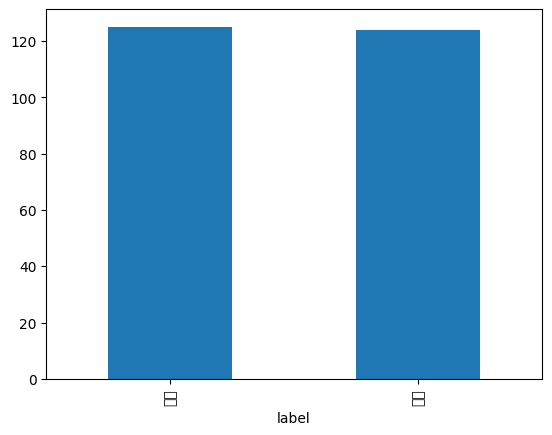

In [48]:
# plot bar 차트 그리기
final_data['label'].value_counts().plot(kind = 'bar')

### 6. label 숫자로 인코딩

In [51]:
label2class = {'긍정': 0, '부정': 1}
class2label = {0: '긍정', 1: '부정'}
final_data['label'] = final_data['label'].map(label2class)

In [53]:
final_data.head()

,data,label
0,재미는 있는데 시간이 짧은게 아쉽네요,0
1,관련 내용은 우리 직원과는 거리가 멀었음 특히 사내에 홍보할 내용은 아니라고 봄,1
2,스토리가 너무 딱딱해서 별로였음,1
3,프로그램 화이팅하세요,0
4,높은 곳에 올라가는 모습이 너무 위험해 보여요,1


In [55]:
# DataFrame 저장
# index = False: Tells pandas not to write the DataFrame's row labels (the index) into the CSV file
# By default, pandas includes the index as the first column in the output.
# Setting index = False prevents that extra column from appearing
final_data.to_csv('A_comment.csv', index = False)

### 7. X, Y 분리

In [58]:
# X, Y 분리
features = final_data['data'].values
labels = final_data['label'].values

In [60]:
features.shape, labels.shape

((249,), (249,))

In [62]:
features[:3]

array(['재미는 있는데 시간이 짧은게 아쉽네요',
       '관련 내용은 우리 직원과는 거리가 멀었음 특히 사내에 홍보할 내용은 아니라고 봄',
       '스토리가 너무 딱딱해서 별로였음'], dtype=object)

In [64]:
print('이벤트 문자열 최대 길이 : {}'.format(max(len(l) for l in features)))
print('이벤트 문자열 평균 길이 : {}'.format(sum(map(len, features))/len(features)))

이벤트 문자열 최대 길이 : 160
이벤트 문자열 평균 길이 : 43.91967871485944


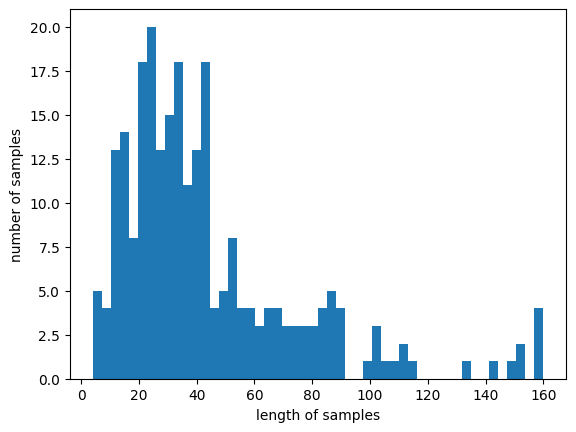

In [66]:
plt.hist([len(s) for s in features], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 8. train set와 test set 분리

In [69]:
from sklearn.model_selection import train_test_split

# stratify: Ensures that the proportion of each class label in the training and test sets matches the proportion in the original dataset
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, stratify = labels, random_state = 41)
x_train.shape, x_test.shape

((199,), (50,))

In [71]:
# 샘플 확인, 0: 긍정, 1: 부정
x_train[:2], y_train[:2]

(array(['저도 입사 개월 갓 지난 신입사원으로써 많이 공감되는 부분이 있고 완전 판매를 위해서 꼼꼼히 케어하여 업무처리해야겠다고 생각되었습니다 매장에서 적용할 부분들에 대해서도 도움이 되고 유쾌하게 풀어내어 이래저래 꾸준히 챙겨보고 있습니다 감사합니다',
        '매 방송마다 신선한 아이디어가 많이 도출되는 것 같아요'], dtype=object),
 array([0, 0]))

### 9. 전체 문장에 대해 Tokenizing
- 컴퓨터가 이해하기 위해 모든 단어를 숫자로 변환해야 함

In [74]:
!pip install tensorflow

In [76]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [78]:
# Tokenizer 구현: 단어 사전 만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [80]:
# 단어에 대한 숫자 매핑
print(tokenizer.word_index)

{'우리': 1, '너무': 2, '것': 3, '잘': 4, '더': 5, '같습니다': 6, '같아요': 7, '좋은': 8, '대한': 9, '수': 10, '좀': 11, '감사합니다': 12, '어떤': 13, '조금': 14, '회사의': 15, '있는': 16, '많이': 17, '회사': 18, '항상': 19, '부분이': 20, '재밌게': 21, '재미있게': 22, '방송': 23, '하는': 24, '프로그램': 25, '정말': 26, '도움이': 27, '고객의': 28, '새로운': 29, '좋겠습니다': 30, '사내': 31, '있었습니다': 32, '방송은': 33, '보고': 34, '응원합니다': 35, '통해': 36, '가장': 37, '쇼핑': 38, '앞으로도': 39, '있습니다': 40, '보는': 41, '어떻게': 42, '보았습니다': 43, '기대됩니다': 44, '차별화된': 45, '다소': 46, '금일': 47, '회사가': 48, '기업이미지': 49, '시간': 50, '아쉬웠습니다': 51, '화이팅': 52, '다양한': 53, '좋을': 54, '합니다': 55, '유익한': 56, '없는': 57, '기획': 58, '많은': 59, '한': 60, '방송이': 61, '서비스': 62, '됩니다': 63, '저도': 64, '케어하여': 65, '되고': 66, '신선한': 67, '전혀': 68, '있어': 69, '잘봤습니다': 70, '최근': 71, '계속': 72, '있었으면': 73, '이미지': 74, '기업의': 75, '참': 76, '있네요': 77, '봤습니다': 78, '아쉽습니다': 79, '있을': 80, '하고': 81, '있는지': 82, '같네요': 83, '함께': 84, '재미있고': 85, '제': 86, '픽은': 87, '마음을': 88, '서비스에': 89, '내용이': 90, '이번': 91, '입니다': 92, '업무를': 93, '모습을':

In [82]:
print(tokenizer.index_word)

{1: '우리', 2: '너무', 3: '것', 4: '잘', 5: '더', 6: '같습니다', 7: '같아요', 8: '좋은', 9: '대한', 10: '수', 11: '좀', 12: '감사합니다', 13: '어떤', 14: '조금', 15: '회사의', 16: '있는', 17: '많이', 18: '회사', 19: '항상', 20: '부분이', 21: '재밌게', 22: '재미있게', 23: '방송', 24: '하는', 25: '프로그램', 26: '정말', 27: '도움이', 28: '고객의', 29: '새로운', 30: '좋겠습니다', 31: '사내', 32: '있었습니다', 33: '방송은', 34: '보고', 35: '응원합니다', 36: '통해', 37: '가장', 38: '쇼핑', 39: '앞으로도', 40: '있습니다', 41: '보는', 42: '어떻게', 43: '보았습니다', 44: '기대됩니다', 45: '차별화된', 46: '다소', 47: '금일', 48: '회사가', 49: '기업이미지', 50: '시간', 51: '아쉬웠습니다', 52: '화이팅', 53: '다양한', 54: '좋을', 55: '합니다', 56: '유익한', 57: '없는', 58: '기획', 59: '많은', 60: '한', 61: '방송이', 62: '서비스', 63: '됩니다', 64: '저도', 65: '케어하여', 66: '되고', 67: '신선한', 68: '전혀', 69: '있어', 70: '잘봤습니다', 71: '최근', 72: '계속', 73: '있었으면', 74: '이미지', 75: '기업의', 76: '참', 77: '있네요', 78: '봤습니다', 79: '아쉽습니다', 80: '있을', 81: '하고', 82: '있는지', 83: '같네요', 84: '함께', 85: '재미있고', 86: '제', 87: '픽은', 88: '마음을', 89: '서비스에', 90: '내용이', 91: '이번', 92: '입니다', 93: '업무를', 94: '모

In [84]:
# 단어별 빈도 수 확인
print(tokenizer.word_counts)

OrderedDict({'저도': 3, '입사': 1, '개월': 1, '갓': 1, '지난': 1, '신입사원으로써': 1, '많이': 8, '공감되는': 1, '부분이': 7, '있고': 1, '완전': 1, '판매를': 1, '위해서': 1, '꼼꼼히': 2, '케어하여': 3, '업무처리해야겠다고': 2, '생각되었습니다': 2, '매장에서': 2, '적용할': 2, '부분들에': 2, '대해서도': 2, '도움이': 6, '되고': 3, '유쾌하게': 2, '풀어내어': 2, '이래저래': 2, '꾸준히': 1, '챙겨보고': 1, '있습니다': 4, '감사합니다': 10, '매': 1, '방송마다': 1, '신선한': 3, '아이디어가': 1, '도출되는': 1, '것': 33, '같아요': 14, '아직은': 1, '들이': 2, '미숙해보이네요': 1, '어색한': 1, '말이': 2, '들려요': 1, '저희': 2, '우리': 35, '회사직원분들과': 1, '호흡도': 1, '좋았고': 1, '진행이': 2, '상당히': 1, '매끄로워': 1, '보는': 4, '내내': 1, '즐거웠습니다': 1, '직원분들도': 1, '전혀': 3, '꿀리는거': 1, '없이': 1, '너무': 35, '능숙해': 1, '지셨네요': 1, '분량이': 1, '치우쳐': 1, '있어': 3, '앞부분의': 1, '내용은': 2, '기억에': 2, '잘': 28, '안남는': 1, '같습니다': 18, '고객의': 6, '입장에서': 1, '생각하면': 1, '새로운': 6, '트렌드가': 1, '보이는': 2, '재밌게': 7, '잘봤습니다': 3, '송씨가': 1, '출근하자마자': 1, '안마의자': 1, '앉아서': 1, '쉬는게': 1, '부럽기도': 1, '했네요쇼호스트분들의': 1, '진행솜씨또한': 1, '감탄하고': 1, '갑니다': 2, '다음은': 1, '어디': 1, '외부': 2, '탐방': 1, '예정인가요': 1, '우리회사와':

In [86]:
# 총 단어 개수: 1418
max_words = len(tokenizer.index_word)
print(max_words)

1418


### 10. texts_to_sequences: 문장을 숫자로 나열

In [89]:
# 문장을 숫자로 나열
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [91]:
print(len(x_train_seq), len(x_test_seq))

199 50


In [93]:
print(x_train[1:3])
print(x_train_seq[1:3])

['매 방송마다 신선한 아이디어가 많이 도출되는 것 같아요' '아직은 들이 미숙해보이네요 어색한 말이 많이 들려요']
[[311, 312, 67, 313, 17, 314, 3, 7], [315, 133, 316, 317, 134, 17, 318]]


### 11. Padding Sequence

In [96]:
# 문장의 최대 길이 파악
max(len(line) for line in x_train_seq)

36

In [98]:
# 모든 문장을 최대 문장 길이 36에 맞춘다
x_train_pad = pad_sequences(x_train_seq, maxlen = 36)
x_test_pad = pad_sequences(x_test_seq, maxlen = 36)

In [100]:
x_train_pad[:1]

array([[  0,   0,   0,   0,   0,   0,  64, 299, 300, 301, 302, 303,  17,
        304,  20, 305, 306, 307, 308, 123,  65, 124, 125, 126, 127, 128,
        129,  27,  66, 130, 131, 132, 309, 310,  40,  12]], dtype=int32)

In [102]:
x_train_pad.shape, x_test_pad.shape

((199, 36), (50, 36))

### 12. 모델링

In [105]:
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPool2D
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, SimpleRNN, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [107]:
max_words = 1418 + 1 # 총 단어 개수 + padding 0 번호
max_len = 36 # 최대 문장 길이
embedding_dim = 32

In [109]:
# 모델 선언
model = Sequential()

In [111]:
# 단어를 의미 있는 32차원으로 Vector 변경
model.add(Embedding(input_dim = max_words, output_dim = embedding_dim, input_length = max_len))

/Users/shinjoohwan/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [113]:
model.add(LSTM(16, return_sequences=True))
model.add(Flatten())
model.add(Dense(128, activation = 'swish'))
model.add(Dense(32, activation = 'swish'))
model.add(Dense(2, activation = 'softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [115]:
# 조기종료 콜백 함수 정의
es = EarlyStopping(monitor='val_loss', patience = 10, verbose =1)

# 체크포인트 저장
checkpoint_path = 'tmp_checkpoint.weights.h5'
cp = ModelCheckpoint(checkpoint_path, save_weights_only = True, monitor = 'val_loss',
                    verbose = 1, save_best_only = True)

In [117]:
%%time
history = model.fit(x_train_pad, y_train, epochs = 50, batch_size = 512,
                   validation_split = 0.2, verbose = 1, callbacks = [es, cp])

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.4654 - loss: 0.6933
Epoch 1: val_loss improved from inf to 0.69276, saving model to tmp_checkpoint.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step - accuracy: 0.4654 - loss: 0.6933 - val_accuracy: 0.4750 - val_loss: 0.6928
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5912 - loss: 0.6916
Epoch 2: val_loss did not improve from 0.69276
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5912 - loss: 0.6916 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6226 - loss: 0.6896
Epoch 3: val_loss did not improve from 0.69276
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6226 - loss: 0.6896 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6604 - loss: 0.6870
Epoch 4: val_loss did not improve from 0.69276
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6604 - loss: 0.6870 - val_accuracy: 0.475

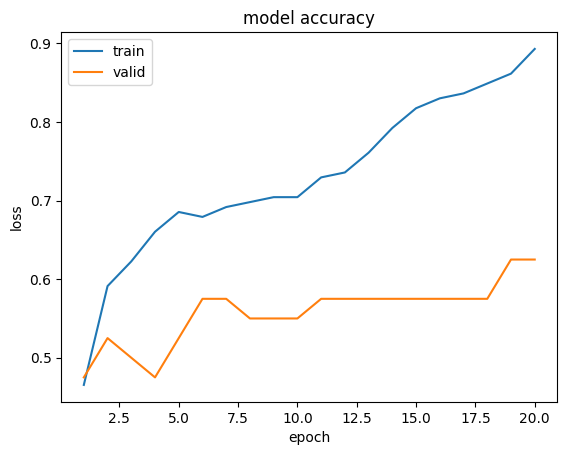

In [119]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [121]:
model.evaluate(x_test_pad, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6112 - loss: 0.6461


[0.6379194855690002, 0.6200000047683716]

### 예측해보기

In [126]:
print(f'문자열: {x_test[0]}')
print(f'Sequence: {x_test_pad[0]}')

문자열: 관련 내용은 우리 직원과는 거리가 멀었음 특히 사내에 홍보할 내용은 아니라고 봄
Sequence: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 481 137   1 137]


In [128]:
predict = model.predict(x_test_pad[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [130]:
print(f'True: {class2label[y_test[0]]}')
print(f'Predict: {class2label[np.argmax(predict)]}')

True: 부정
Predict: 부정
